In [1]:
import pandas as pd
from sklearn import cross_validation,metrics, grid_search, linear_model
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt
import seaborn 
import xgboost as xgb
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [24]:
def load_data(Balint = False, dataset=None):
    angle = pd.read_csv('angle', sep=',', header=None)
    SS = pd.read_csv('StructuralSums', header=None)
    real = pd.read_csv('real', header=None)
    volume = pd.read_csv('volume', header = None)
    order = pd.read_csv('order', header=None)
    E = pd.read_csv('Energy', header=None)
    E_Balint = pd.read_csv('Energy_Balint', header=None)
    poscar = pd.read_csv('Poscars', header = None)
    
    E_Balint = E_Balint.drop(0, axis=1)
    
    name_list = ['angle', 'SS', 'real', 'volume', 'order']
    data_list = [angle, SS, real, volume, order]
    
    for i in range(len(data_list)):
        index = []
        for j in range(data_list[i].shape[1]):
            index.append(name_list[i] + '%i'% j)
        data_list[i].set_axis(1,[index])
    
    coefs = []
    
    for i in range(len(poscar)):
        if poscar[0][i] == 'Au':
            coefs.append(poscar[0][i+1])
    coefs = pd.DataFrame(coefs)
    for i in range(len(E)):
        E[0][i] = E[0][i]/float(coefs[0][i])
        E_Balint[1][i] = E_Balint[1][i]/float(coefs[0][i])
    FP = pd.concat([angle, SS, real, volume, order], axis=1)
    
    
    index = []
    for i in range(len(E[0])):
        if E[0][i] > 0:
            index.append(i)
    E = E.drop(index)
    E_Balint = E_Balint.drop(index)
    FP = FP.drop(index)
    
    
    if dataset == 'old_FP':
        X = FP.astype(np.float32)
        print 'Old FP used'
    if dataset == 'new_FP':
        X = pd.read_csv('FP', sep=',', header = None, dtype=np.float32)
        X = X.drop(index)
        print 'New FP used'
    if not Balint: 
        y = E[0].astype(np.float32)
        print "DFT loaded"
    else:
        y = E_Balint[1].astype(np.float32)
        print "Balint loaded"
    return X,y
    
        
        

def boost_test(estimator, X_train, y_train, X_test, y_test):
    estimator.fit(X_train, y_train)
    predicts = estimator.predict(X_test)
    mae = metrics.mean_absolute_error(y_test, predicts)
    mse = metrics.mean_squared_error(y_test, predicts)
    rmse = np.sqrt(mse)
    errors = np.asarray([mae, mse, rmse])
    return predicts, errors
def get_X_slice(X, indices):
    return X[X.columns[indices]]
def TVT_split(X,y):
    data_len = X.shape[0]
    test_shape = int(0.5*data_len)
    val_shape = int(0.25*data_len)
    X_train = np.asarray(X[:][:-test_shape], dtype=np.float32)
    y_train = np.asarray(y[:-test_shape], dtype=np.float32)
    X_val = np.asarray(X[:][test_shape:test_shape+val_shape], dtype=np.float32)
    y_val = np.asarray(y[test_shape:test_shape+val_shape], dtype=np.float32)
    X_test = np.asarray(X[:][-test_shape+val_shape:], dtype=np.float32)
    y_test = np.asarray(y[-test_shape+val_shape:], dtype=np.float32)
    return X_train, y_train, X_val, y_val, X_test, y_test

def compose(ytest, dyxgb, dyrf, c1, c2):
    dy = c1*dyxgb + c2*dyrf
    ypred = ytest + dy
    return ypred

In [3]:
X,y = load_data(dataset='old_FP', Balint=False)
print X.shape, y.shape

Old FP used
DFT loaded
(11627, 48) (11627,)


In [4]:
Xb, yb = load_data(dataset='old_FP', Balint=True)

Old FP used
Balint loaded


In [75]:
for a in yb:
    if a>0:
        print a

164.722


In [6]:
for i in yb:
    if i>0:
        print i
        X.drop(yb[yb==i].index[0], inplace=True)
        y.drop(yb[yb==i].index[0], inplace=True)
        yb.drop(yb[yb==i].index[0], inplace=True)
X.index = range(0,len(X))
y.index = range(0,len(y))
yb.index = range(0,len(yb))

In [69]:
xtrain, xtest, ytrain, ytest =cross_validation.train_test_split(X, y, test_size = 0.3)

In [9]:
for itr, ite in cross_validation.ShuffleSplit(len(y), n_iter=5, train_size=0.75, test_size=0.25, random_state=0):
    pass

In [10]:
xtrain = X.loc[itr]
xtest = X.loc[ite]

ytrain = y.loc[itr]
ytest = y.loc[ite]

ybtrain = yb.loc[itr]
ybtest = yb.loc[ite]

dytrain = ytrain - ybtrain
dytest = ytest - ybtest

In [11]:
def graph(res):
    y = []
    for i in range(len(res)):
        y.append(float(str(res[i].split(':')[1][0:8])))
    x = range(0,len(res))
    plt.plot(x, y)
    plt.show()

In [12]:
#gbtree
param = {}
param['max_depth'] = 100
param['subsample'] = 0.75
param['rate_drop'] = 0.5
param['booster'] = 'gbtree'
param['objective'] = 'reg:linear'
param['eval_metric'] = 'rmse'
param['eta'] = 0.01

numround = 1000

In [18]:
#gblinear
param = {}
param['max_depth'] = 50
param['subsample'] = 0.75
param['rate_drop'] = 0.5
param['booster'] = 'gblinear'
param['objective'] = 'reg:linear'
param['eval_metric'] = 'rmse'
param['eta'] = 0.3

numround = 1000

[0]	cv-test-rmse:0.625435+0.005086	cv-train-rmse:0.624767+0.001275
[1]	cv-test-rmse:0.620640+0.005097	cv-train-rmse:0.619259+0.001263
[2]	cv-test-rmse:0.615888+0.005065	cv-train-rmse:0.613852+0.001234
[3]	cv-test-rmse:0.611172+0.004987	cv-train-rmse:0.608464+0.001228
[4]	cv-test-rmse:0.606530+0.004958	cv-train-rmse:0.603136+0.001209
[5]	cv-test-rmse:0.601989+0.004941	cv-train-rmse:0.597867+0.001166
[6]	cv-test-rmse:0.597467+0.004897	cv-train-rmse:0.592656+0.001159
[7]	cv-test-rmse:0.592982+0.004822	cv-train-rmse:0.587490+0.001141
[8]	cv-test-rmse:0.588589+0.004766	cv-train-rmse:0.582385+0.001140
[9]	cv-test-rmse:0.584163+0.004714	cv-train-rmse:0.577316+0.001125
[10]	cv-test-rmse:0.579838+0.004690	cv-train-rmse:0.572311+0.001130
[11]	cv-test-rmse:0.575524+0.004661	cv-train-rmse:0.567342+0.001112
[12]	cv-test-rmse:0.571321+0.004639	cv-train-rmse:0.562431+0.001112
[13]	cv-test-rmse:0.567167+0.004620	cv-train-rmse:0.557549+0.001111
[14]	cv-test-rmse:0.563066+0.004615	cv-train-rmse:0.552718

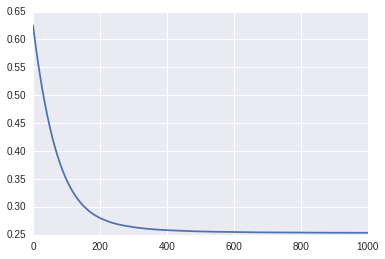

In [13]:
Xdatatrain = xgb.DMatrix(data = xtrain, label = dytrain)
#Xdatatest = xgboost.DMatrix(data = xval, label = yval)

plst = list(param.items())
#watchlist = [(Xdatatrain, 'train'), (Xdatatest, 'eval')]            

res = xgb.cv(params=param, dtrain=Xdatatrain, num_boost_round=numround, nfold=5)
graph(res)

In [14]:
bst = xgb.train(plst, Xdatatrain, numround)

In [15]:
ypredxgb = bst.predict(xgb.DMatrix(xtest))
print np.sqrt(metrics.mean_squared_error(dytest, ypredxgb))

0.235324


In [16]:
ypred = ybtest + ypredxgb

In [26]:
metrics.mean_absolute_error(ytest, ypred)

0.095769703

In [166]:
print ypred.values[156:161]
print ytest.values[156:161]

[-2.57292986 -2.68506336 -2.86828566 -2.99439716 -2.5362978 ]
[-2.75955749 -2.82195473 -2.95415092 -3.09892559 -2.76765728]


In [18]:
from sklearn.ensemble import RandomForestRegressor

In [21]:
reg = RandomForestRegressor(n_estimators=100, criterion='mse', max_depth=25)

In [25]:
reg.fit(xtrain, dytrain)
dyrf = reg.predict(xtest)
pred = ybtest + predrf
metrics.mean_absolute_error(ytest, pred)

0.10957947826771958

In [49]:
c1 = np.arange(0,1.001,0.001)
results = [[],[]]
for ind1 in c1:
    ind2 = 1 - ind1
    ypred = compose(ybtest,ypredxgb, dyrf,ind1,ind2)
    err = metrics.mean_absolute_error(ytest, ypred)
    results[0].append(err)
    results[1].append([ind1,ind2])

In [50]:
print min(results[0])
print np.argmin(results[0])
print results[1][np.argmin(results[0])]

0.0957696968142
1000
[1.0, 0.0]


In [51]:
%%time
X_train, X_test, y_train, y_test =cross_validation.train_test_split(X, y, test_size = 0.3)
preds, errors = boost_test(boost, X_train, y_train, X_test, y_test)
print errors

[ 0.13332824  0.08384796  0.28956512]
CPU times: user 35.9 s, sys: 104 ms, total: 36 s
Wall time: 4.73 s


In [17]:
X_train, X_test, y_train, y_test =cross_validation.train_test_split(X, y, test_size = 0.3)

In [18]:
predicts, errors = xgb_test(boost, X_train
                            , y_train, X_test, y_test)
print errors

[ 0.12609257  0.07559063  0.27493751]


In [65]:
%run NN_module.ipynb

In [77]:
nn = net.fit(X_train, y_train)

     91     7.98602     7.76006    1.02912  0.04s
     92     7.98602     7.76006    1.02912  0.03s
     93     7.98602     7.76006    1.02912  0.03s
     94     7.98602     7.76006    1.02912  0.03s
     95     7.98602     7.76006    1.02912  0.03s
     96     7.98602     7.76006    1.02912  0.03s
     97     7.98602     7.76006    1.02912  0.03s
     98     7.98602     7.76006    1.02912  0.03s
     99     7.98602     7.76006    1.02912  0.03s
    100     7.98602     7.76006    1.02912  0.03s
    101     7.98602     7.76006    1.02912  0.03s
    102     7.98602     7.76006    1.02912  0.03s
    103     7.98602     7.76006    1.02912  0.03s
    104     7.98602     7.76006    1.02912  0.03s
    105     7.98602     7.76006    1.02912  0.03s


In [78]:
pred = net.predict(X_test)

In [79]:
pred !=0

array([[False],
       [False],
       [False],
       ..., 
       [False],
       [False],
       [False]], dtype=bool)

In [80]:
for a in pred:
    if a:
        print a

[ 0.13972823]
[ 0.11511834]
[ 0.11819609]
[ 0.15689097]
[ 0.15615766]
[ 0.15830909]
[ 0.23949207]
[ 0.13811542]
[ 0.04324849]
[ 0.08343149]
[ 0.07531467]
[ 0.00515585]
[ 0.05194105]
[ 0.07020428]
[ 0.07890538]
[ 0.0813802]
[ 0.08018645]
[ 0.07964513]
[ 0.08103983]
[ 0.08114468]
[ 0.0820155]
[ 0.08223825]
[ 0.06983566]
[ 0.06587856]
[ 0.07102431]
[ 0.07262965]
[ 0.04757836]
[ 0.0435136]
[ 0.04724526]
[ 0.04896252]
[ 0.04866171]
[ 0.06043109]
[ 0.04614555]


In [81]:
metrics.mean_absolute_error(y_test, pred)

2.7648091